# Course 1: Classification and Vector Spaces
# Own project 1: Classifying positivity on my own tweets

In this notebook I will apply the knowledge I gained from the previous notebooks to classify tweets as positive or negative on my own data.

## Libraries

In [1]:
import nltk
import numpy as np
import pandas as pd 
import tweepy
import json
import os
import re
import pickle

import unidecode
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.corpus import twitter_samples

from tqdm.notebook import tqdm

## Prepare the data

### Own tweets
These tweets will be the data where I will make predictions.

In [2]:
me = "fcx_xm"

with open("twitter-api-keys.local.json") as f:
    keys = json.load(f)
    api_key = keys["api_key"]
    api_key_secret = keys["api_key_secret"]
    access_token = keys["access_token"]
    access_token_secret = keys["access_token_secret"]
    bearer_token = keys["bearer_token"]

# Get my latest 200 tweets
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweets = api.user_timeline(screen_name=me, count=200, tweet_mode="extended", include_rts=False)

In [35]:
# If tweets.pkl exists, load it. Otherwise, save the tweets to tweets.pkl
if os.path.exists("tweets.pkl"):
    with open("tweets.pkl", "rb") as f:
        tweets = pickle.load(f)
else:
    limit = 20000
    tweet_cursor = tweepy.Cursor(api.user_timeline, screen_name=me, count=200, tweet_mode="extended", include_rts=False).items(limit)
    tweets = []
    for tweet in tqdm(tweet_cursor):
        tweets.append(tweet)
    with open("tweets.pkl", "wb") as f:
        pickle.dump(tweets, f)

0it [00:00, ?it/s]

In [4]:
# Type, len
print(type(tweets))
print(len(tweets))

# Print 5 random tweets
for tweet in np.random.choice(tweets, 5):
    print(tweet.full_text)
    print("\n")

<class 'list'>
2174
https://t.co/ABinyaONLl


https://t.co/ZmlKKfHmhT


me estan dejando de encajar los piños qiza es hora de ponerse el retenedor dsps de mmm nose 5 meses


qe te calles 7 veces pollasucia https://t.co/T9x5JDNAmi


tengo q ir a renovar el dnie plan de viernes tarde 😳😋




### Training data

A IMDB dataset will be used to train the model. It contains reviews of movies and their sentiment.

In [5]:
# Load IMDB_clean.csv
imdb_df = pd.read_csv("IMDB_clean.csv")
# In review_es, transform "positivo" to 1 and "negativo" to 0 in column sentimiento
imdb_df["sentimiento"] = imdb_df["sentimiento"].replace({"positivo": 1, "negativo": 0})

In [6]:
imdb_df.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


In [7]:
# Make two lists of reviews and their labels
reviews = imdb_df["review_es"].tolist()
labels = imdb_df["sentimiento"].tolist()

# Split into train and test. X is reviews, y is labels
train_x = reviews[:int(len(reviews) * 0.8)]
train_y = labels[:int(len(labels) * 0.8)]
test_x = reviews[int(len(reviews) * 0.8):]
test_y = labels[int(len(labels) * 0.8):]

In [8]:
print("\nTrain set:")
print(len(train_x))
print(len(train_y))
print("\nTest set:")
print(len(test_x))
print(len(test_y))


Train set:
40000
40000

Test set:
10000
10000


In [9]:
# Process review function

def process_review(review):
    """
    Input:
        - A string containing a review
    Output:
        - A list of words containing the processed review
    """
    
    stemmer = nltk.SnowballStemmer("spanish")
    stopwords_es = stopwords.words("spanish")
    # Remove accents from stopwords and remove duplicates
    stopwords_es = [unidecode.unidecode(w) for w in stopwords_es]
    stopwords_es = list(set(stopwords_es))
    # Clean
    review = re.sub(r'^RT[\s]+', '', review)
    review = re.sub(r'https?:\/\/.*[\r\n]*', '', review)
    review = re.sub(r'#', '', review)
    review = review.lower()
    review = review.strip()
    review = unidecode.unidecode(review) #remove accents
    
    # Tokenize
    review_tokens = nltk.word_tokenize(review, "spanish")

    # Remove symbols
    review_tokens = [token for token in review_tokens if token.isalpha()]

    # Token, stem, remove stopwords
    reviews_clean = []

    for token in review_tokens:
        if token not in stopwords_es:
            reviews_clean.append(stemmer.stem(token))

    return reviews_clean


In [10]:
# Clean 5 random reviews
print("\nRandom 5 reviews:")
for review in np.random.choice(train_x, 5):
    print(process_review(review))
    print()



Random 5 reviews:
['legendari', 'productor', 'pelicul', 'walt', 'disney', 'traj', 'tres', 'mejor', 'cuent', 'had', 'mund', 'pantall', 'permanec', 'pelicul', 'anim', 'popular', 'tiemp', 'primer', 'innov', 'clasic', 'blancaniev', 'niev', 'siet', 'enanit', 'lanz', 'ultim', 'entonc', 'baj', 'apreci', 'bell', 'durmient', 'hiz', 'debut', 'dos', 'quiz', 'adaptacion', 'satisfactori', 'clasic', 'cuent', 'had', 'cinderell', 'tres', 'pelicul', 'cinderell', 'fiel', 'origen', 'iron', 'diferent', 'blancaniev', 'bien', 'mal', 'convirti', 'much', 'version', 'definit', 'histori', 'cinderell', 'sigui', 'mism', 'camin', 'aunqu', 'exit', 'blancaniev', 'respons', 'restaur', 'donador', 'disney', 'fortun', 'nunc', 'logr', 'mism', 'reconoc', 'audienci', 'ciert', 'mereci', 'disney', 'vez', 'orgull', 'eligi', 'manipul', 'clasic', 'cambi', 'elabor', 'agreg', 'sustanci', 'histori', 'lug', 'reescrib', 'pantall', 'result', 'encant', 'combinacion', 'excelent', 'animacion', 'tecnic', 'bell', 'suav', 'talent', 'voz',

In [11]:
# Build freqs function
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in tqdm(zip(yslist, tweets), total=len(tweets)):
        for word in process_review(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [12]:
# Check with pickle if freqs.pkl exists. If not calculate freqs and save
if os.path.exists("freqs.pkl"):
    with open("freqs.pkl", "rb") as f:
        freqs = pickle.load(f)
else:
    freqs = build_freqs(train_x, train_y)
    with open("freqs.pkl", "wb") as f:
        pickle.dump(freqs, f)

In [13]:
# Print len and type
print("\nFreqs:")
print(len(freqs))
print(type(freqs))


Freqs:
127763
<class 'dict'>


## Logistic Regression

In [14]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [15]:
# Test it
print("\nSigmoid of 0:")
print(sigmoid(0))
print("\nSigmoid of 1:")
print(sigmoid(1))


Sigmoid of 0:
0.5

Sigmoid of 1:
0.7310585786300049


## Gradient descent. CPU and GPU

For the gradient descent, in order to process the large dataset, I will use a GPU approach using CuPy.

In [16]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(),np.log(1-h)))    

        # update the weights theta
        theta = theta = theta - (alpha/m) * np.dot(x.transpose(),(h-y))
        
    ### END CODE HERE ###
    J = float(J)
    return J, theta

In [17]:
import cupy as cp

def gradientDescent_gpu(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # get 'm', the number of rows in matrix x
    m = x.shape[0]

    # Convert to cupy arrays
    x = cp.array(x)
    y = cp.array(y)
    theta = cp.array(theta)
    
    
    for i in tqdm(range(0, num_iters)):
        
        # get z, the dot product of x and theta
        z = cp.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        h = cp.array(h)
        
        # calculate the cost function
        J = -1./m * (cp.dot(y.transpose(), cp.log(h)) + cp.dot((1-y).transpose(),cp.log(1-h)))

        # update the weights theta
        theta = theta - (alpha/m) * cp.dot(x.transpose(),(h-y))
        
    ### END CODE HERE ###
    J = float(J)
    theta = theta.get()
    return J, theta

In [18]:
# Check the two functions
np.random.seed(1)
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")


The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


In [19]:
# Test the GPU version
tmp_J, tmp_theta = gradientDescent_gpu(tmp_X, tmp_Y, cp.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

  0%|          | 0/700 [00:00<?, ?it/s]

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


## Feature extraction

In [20]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_review(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 

    
    # loop through each word in the list of words
    for word in word_l:        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.0),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.0),0)
        
    assert(x.shape == (1, 3))
    return x

In [21]:
# Features of two random reviews
print("\nFeatures of two phrases")
print(extract_features("Ayer estuve genial", freqs)) # a positive example
print(extract_features("Hoy estamos muy mal", freqs)) # a negative one


Features of two phrases
[[1.00e+00 1.75e+03 9.59e+02]]
[[1.0000e+00 5.3690e+03 1.3958e+04]]


## Model training

Here we will train the model using the training data, and the GPU version of the gradient descent.

In [22]:
X = np.zeros((len(train_x), 3))

# Check if features.pkl exists
if os.path.exists("features.pkl"):
    with open("features.pkl", "rb") as f:
        X = pickle.load(f)
else:
    for i in tqdm(range(len(train_x))):
        X[i, :]= extract_features(train_x[i], freqs)
    with open("features.pkl", "wb") as f:
        pickle.dump(X, f)


In [23]:
# For each train_y if == 1 then Y[i] = np.ones(1,1) else Y[i] = np.zeros(1,1)
Y = np.zeros((len(train_y), 1))
for i in range(len(train_y)):
    if train_y[i] == 1:
        Y[i, 0] = 1
    else:
        Y[i, 0] = 0

In [24]:
# Print first 10 elements of X and Y
print("\nFirst 10 elements of X and Y")
print(X[:10, :])
print(Y[:10, :])


First 10 elements of X and Y
[[1.00000e+00 2.59999e+05 2.67971e+05]
 [1.00000e+00 1.95620e+05 2.00093e+05]
 [1.00000e+00 1.77269e+05 1.77734e+05]
 [1.00000e+00 4.56248e+05 4.96460e+05]
 [1.00000e+00 5.21486e+05 5.30807e+05]
 [1.00000e+00 2.48780e+05 2.59603e+05]
 [1.00000e+00 2.37611e+05 2.47525e+05]
 [1.00000e+00 2.20732e+05 2.44603e+05]
 [1.00000e+00 4.21248e+05 4.68492e+05]
 [1.00000e+00 9.73970e+04 1.00945e+05]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [25]:
# Gradient descent
# Only use first 100 samples
train_100 = X[:100, :]
train_100_y = Y[:100, :]

J_100, theta_100 = gradientDescent_gpu(train_100, train_100_y, np.zeros((3, 1)), 1e-8, 700)

  0%|          | 0/700 [00:00<?, ?it/s]

In [26]:
# Print the cost and the resulting weight vector
print("\nThe cost after training is", J_100)
print("The resulting vector of weights is", [round(t, 8) for t in np.squeeze(theta_100)])


The cost after training is nan
The resulting vector of weights is [-1.4e-07, 0.00876147, -0.0081767]


In [27]:
# Train with the entire dataset
J_all, theta_all = gradientDescent_gpu(X, Y, np.zeros((3, 1)), 1e-9, 3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [28]:
print("\nThe cost after training is", J_all)
print("The resulting vector of weights is", [round(t, 8) for t in np.squeeze(theta_all)])


The cost after training is nan
The resulting vector of weights is [1.2e-07, 0.00146131, -0.00129507]


As we can see, there is something wrong with the training data, because we get a division by zero error.
We solved that using the Cuda approach, and getting the weight vector

## Model evaluation

### Making some predictions

In [29]:
def predict_text(text, freqs, theta):
    """
    Input:
        - Text: a list of words
        - freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        - theta: the weight vector of dimension (3,1)
    Output:
        - prediction: a float between 0 and 1
    """
    # Get the feature vector
    x = extract_features(text, freqs)
    # Get the dot product of the feature vector and the weight vector
    z = np.dot(x, theta)
    # Get the sigmoid of the dot product
    h = sigmoid(z)
    # Return the prediction
    return h

In [30]:
# Predict 5 random tweets from tweets_text
# Use 5 random indexes
# tweets text is tweets.full_text from the tweets list
tweets_text = [tweet.full_text for tweet in tweets]
random_indexes = np.random.choice(len(tweets_text), 5, replace=False)
for i in random_indexes:
    # Print the quoted tweet -> prediction
    print("\n", tweets_text[i], "->", predict_text(tweets_text[i], freqs, theta_all))


 lo siento sixto tienes media de 4 en calculo los ultimos 5 años y solo un 30% aprueba la asignatura milagros no hago -> [[0.85275035]]

 finde qe me voy fuera de malaga finde qe me salen 129391239 planes odio esta vida -> [[0.98856361]]

 malisima idea tomarme dos jarras antes de ponerme a estudiar -> [[0.79547013]]

 si jason statham fuera malagueño y se qemase https://t.co/u9aaOvGulB -> [[0.53451258]]

 @warisntover https://t.co/Azy6SF7Yl5 https://t.co/nozgbtN2je -> [[0.50000003]]


In [44]:
# Create df with column tweets_text and column prediction
predictions = pd.DataFrame(columns=["tweets_text", "prediction"])
predictions["tweets_text"] = tweets_text
predictions_list = []
for i in range(len(tweets_text)):
    predictions_list.append(predict_text(tweets_text[i], freqs, theta_all))

predictions["prediction"] = predictions_list

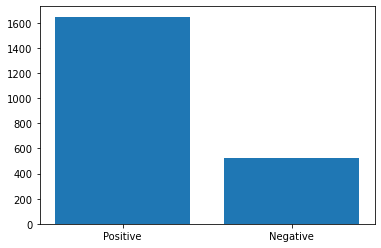

In [45]:
# Count the preditions with > 0.5 and < 0.5
pos_preds = [pred for pred in predictions["prediction"] if pred > 0.5]
neg_preds = [pred for pred in predictions["prediction"] if pred < 0.5]

# Bar plot of the number of positive and negative predictions
plt.bar(["Positive", "Negative"], [len(pos_preds), len(neg_preds)])
plt.show()

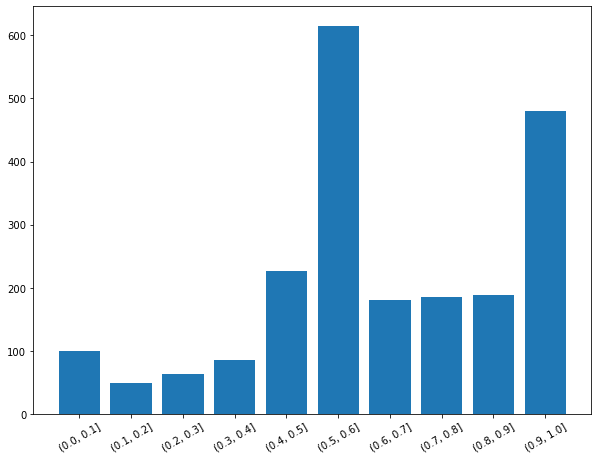

In [66]:
# Create df_bins. Columns predictions, and column bins (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)
df_bins = pd.DataFrame(columns=["predictions", "bins"])
df_bins["predictions"] = predictions["prediction"]
df_bins["bins"] = pd.cut(df_bins["predictions"], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# Bins to strings
df_bins["bins"] = df_bins["bins"].astype(str)

# Group by bins and count the number of predictions
df_bins_count = df_bins.groupby("bins").count()

# Plot size 10x10 figure
plt.figure(figsize=(10, 7.5))
# Plot the number of predictions in each bin
# Bar color goes from red to green depending on the bin
plt.bar(df_bins_count.index, df_bins_count["predictions"])
# x 30 degrees
plt.xticks(rotation=30)
plt.show()


In [70]:
# Print the 5 predictions with the highest prediction
print("\nThe 5 predictions with the highest prediction")
print(predictions.sort_values(by="prediction", ascending=False).head(5))

# Print the 5 predictions with the lowest prediction
print("\nThe 5 predictions with the lowest prediction")
print(predictions.sort_values(by="prediction", ascending=True).head(5))


The 5 predictions with the highest prediction
                                            tweets_text  \
1236  Here’s a song for you… I Met Sarah in the Bath...   
276   increible como todos los tios de mi instituto ...   
1145  los de mi trabajo tienen q conocer ya el 80% d...   
629   the violent urge to comprarme unos chocoboms b...   
607   me gusta qe en una empresa haya buen rollo y d...   

                  prediction  
1236  [[0.9999999610945769]]  
276   [[0.9999999336545007]]  
1145  [[0.9999996636671279]]  
629   [[0.9999994491262499]]  
607     [[0.99999915791048]]  

The 5 predictions with the lowest prediction
                                            tweets_text  \
1882  el truco esta en no esperarse nada nunca solo ...   
1507  ojala fumar solo pa completar el desayuno ener...   
202   otro post de ig que intenta hacerme sentir mal...   
1501  menos mal qe es tele trabajo si no me tendria ...   
69       como de mala idea es ir al gym dsps del buffet   

           

### Checking performance

In [71]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
        
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_text(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = (y_hat==np.squeeze(test_y)).sum()/len(test_x)
    
    return accuracy

In [73]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta_all)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.6011


We get an accuracy of 0.6. This might be caused by a bad translated dataset. If we inspect the dataset, we see incoherent translations, and words that do not exist in the spanish alphabet